In [ ]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

Import necessary libraries for data manipulation, visualization, and random number generation.
Set the visual style for seaborn plots to 'darkgrid' with a light gray axes background.


In [ ]:
def generate_customer_profiles_table(n_customers, random_state=0):

    np.random.seed(random_state)

    customer_id_properties=[]


    for customer_id in range(n_customers):

        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)

        mean_amount = np.random.uniform(5,100)
        std_amount = mean_amount/2

        mean_nb_tx_per_day = np.random.uniform(0,4)

        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])

    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])

    return customer_profiles_table


The function returns the DataFrame, which holds the randomly generated customer profiles.

In [ ]:
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

CUSTOMER_ID  x_customer_id  y_customer_id  mean_amount  std_amount  \
0            0      54.881350      71.518937    62.262521   31.131260   
1            1      42.365480      64.589411    46.570785   23.285393   
2            2      96.366276      38.344152    80.213879   40.106939   
3            3      56.804456      92.559664    11.748426    5.874213   
4            4       2.021840      83.261985    78.924891   39.462446   

   mean_nb_tx_per_day  
0            2.179533  
1            3.567092  
2            2.115580  
3            0.348517  
4            3.480049

In [ ]:
def generate_terminal_profiles_table(n_terminals, random_state=0):

    np.random.seed(random_state)

    terminal_id_properties=[]


    for terminal_id in range(n_terminals):

        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)

        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])

    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])

    return terminal_profiles_table
n_terminals = 5
terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 0)
terminal_profiles_table

TERMINAL_ID  x_terminal_id  y_terminal_id
0            0      54.881350      71.518937
1            1      60.276338      54.488318
2            2      42.365480      64.589411
3            3      43.758721      89.177300
4            4      96.366276      38.344152

In [ ]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):




    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)


    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)


    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))

    available_terminals = list(np.where(dist_x_y<r)[0])

    return available_terminals

In [ ]:
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
customer_profiles_table['available_terminals']=customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50), axis=1)
customer_profiles_table

CUSTOMER_ID  x_customer_id  y_customer_id  mean_amount  std_amount  \
0            0      54.881350      71.518937    62.262521   31.131260   
1            1      42.365480      64.589411    46.570785   23.285393   
2            2      96.366276      38.344152    80.213879   40.106939   
3            3      56.804456      92.559664    11.748426    5.874213   
4            4       2.021840      83.261985    78.924891   39.462446   

   mean_nb_tx_per_day available_terminals  
0            2.179533        [0, 1, 2, 3]  
1            3.567092        [0, 1, 2, 3]  
2            2.115580              [1, 4]  
3            0.348517        [0, 1, 2, 3]  
4            3.480049              [2, 3]

In [ ]:
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):

    customer_transactions = []

    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))

    # For all days
    for day in range(nb_days):


        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)


        if nb_tx>0:

            for tx in range(nb_tx):


                time_tx = int(np.random.normal(86400/2, 20000))


                if (time_tx>0) and (time_tx<86400):

                    # Amount is drawn from a normal distribution
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)

                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)

                    amount=np.round(amount,decimals=2)

                    if len(customer_profile.available_terminals)>0:

                        terminal_id = random.choice(customer_profile.available_terminals)

                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID,
                                                      terminal_id, amount])

    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])

    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]

    return customer_transactions

In [ ]:
transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df

<ipython-input-8-fd68e4ae6309>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)


TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  TX_TIME_SECONDS  \
0  2018-04-01 07:19:05            0            3     123.59            26345   
1  2018-04-01 19:02:02            0            3      46.51            68522   
2  2018-04-01 18:00:16            0            0      77.34            64816   
3  2018-04-02 15:13:02            0            2      32.35           141182   
4  2018-04-02 14:05:38            0            3      63.30           137138   
..                 ...          ...          ...        ...              ...   
60 2018-04-05 07:41:19            4            2     111.38           373279   
61 2018-04-05 06:59:59            4            3      80.36           370799   
62 2018-04-05 17:23:34            4            2      53.25           408214   
63 2018-04-05 12:51:38            4            2      36.44           391898   
64 2018-04-05 12:38:46            4            3      17.53           391126   

    TX_TIME_DAYS  
0              0  
1              0  
2              0  
3              1  
4              1  
..           ...  
60             4  
61             4  
62             4  
63             4  
64             4  

[65 rows x 6 columns]

In [ ]:
def generate_dataset(n_customers, n_terminals, nb_days,r=5):

    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))

    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))

    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))

    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))

    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)

    return (customer_profiles_table, terminal_profiles_table, transactions_df)


In [ ]:
(customer_profiles_table, terminal_profiles_table, transactions_df)= generate_dataset(n_customers = 5000, n_terminals = 10000, nb_days=183,r=5)

Time to generate customer profiles table: 0.24s
Time to generate terminal profiles table: 0.15s
Time to associate terminals to customers: 6.3s


<ipython-input-9-d670a6463df4>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
<ipython-input-9-d670a6463df4>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_day

Time to generate transactions: 1.4e+02s


In [ ]:
transactions_df

TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  \
0                     0 2018-04-01 00:00:31         596        3156   
1                     1 2018-04-01 00:02:10        4961        3412   
2                     2 2018-04-01 00:07:56           2        1365   
3                     3 2018-04-01 00:09:29        4128        8737   
4                     4 2018-04-01 00:10:34         927        9906   
...                 ...                 ...         ...         ...   
1754150         1754150 2018-09-30 23:56:36         161         655   
1754151         1754151 2018-09-30 23:57:38        4342        6181   
1754152         1754152 2018-09-30 23:58:21         618        1502   
1754153         1754153 2018-09-30 23:59:52        4056        3067   
1754154         1754154 2018-09-30 23:59:57        3542        9849   

         TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  
0            57.16              31            0  
1            81.51             130            0  
2           146.00             476            0  
3            64.49             569            0  
4            50.99             634            0  
...            ...             ...          ...  
1754150      54.24        15810996          182  
1754151       1.23        15811058          182  
1754152       6.62        15811101          182  
1754153      55.40        15811192          182  
1754154      23.59        15811197          182  

[1754155 rows x 7 columns]

In [ ]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):

    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0

    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))

    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):

        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)

        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+28) &
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]

        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2

    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))

    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):

        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values

        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                    (transactions_df.TX_TIME_DAYS<day+14) &
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]

        nb_compromised_transactions=len(compromised_transactions)


        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))

        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3


    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))

    return transactions_df

Scenario 1: Any transaction whose amount is more than 220 is a fraud.

Scenario 2: Every day, a list of two terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent.

Scenario 3: Every day, a list of 3 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked.


In [ ]:
transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 978
Number of frauds from scenario 2: 9099
Number of frauds from scenario 3: 4604


In [ ]:
transactions_df.head()


TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      64.49   
4               4 2018-04-01 00:10:34         927        9906      50.99   

  TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0              31            0         0                  0  
1             130            0         0                  0  
2             476            0         0                  0  
3             569            0         0                  0  
4             634            0         0                  0

# Date and time transformations

In [ ]:
def is_weekend(tx_datetime):


    weekday = tx_datetime.weekday()
    is_weekend = weekday>=5

    return int(is_weekend)

It will characterize whether a transaction occurs during a weekday (value 0) or a weekend (1), and will be called TX_DURING_WEEKEND

In [ ]:
%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

CPU times: user 4.76 s, sys: 239 ms, total: 5 s
Wall time: 5.05 s


In [ ]:
def is_night(tx_datetime):

    tx_hour = tx_datetime.hour
    is_night = tx_hour<=6

    return int(is_night)

It will characterize whether a transaction occurs during the day or during the day (0) or during the night (1). The night is defined as hours that are between 0pm and 6am. It will be called TX_DURING_NIGHT.

In [ ]:
%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

CPU times: user 3.78 s, sys: 153 ms, total: 3.93 s
Wall time: 3.9 s


In [ ]:
transactions_df[transactions_df.TX_TIME_DAYS>=30]

TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  \
288062           288062 2018-05-01 00:01:21        3546        2944   
288063           288063 2018-05-01 00:01:48         206        3521   
288064           288064 2018-05-01 00:02:22        2610        4470   
288065           288065 2018-05-01 00:03:15        4578        1520   
288066           288066 2018-05-01 00:03:51        1246        7809   
...                 ...                 ...         ...         ...   
1754150         1754150 2018-09-30 23:56:36         161         655   
1754151         1754151 2018-09-30 23:57:38        4342        6181   
1754152         1754152 2018-09-30 23:58:21         618        1502   
1754153         1754153 2018-09-30 23:59:52        4056        3067   
1754154         1754154 2018-09-30 23:59:57        3542        9849   

         TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  \
288062       18.71         2592081           30         0                  0   
288063       18.60         2592108           30         0                  0   
288064       66.67         2592142           30         0                  0   
288065       79.41         2592195           30         0                  0   
288066       52.08         2592231           30         0                  0   
...            ...             ...          ...       ...                ...   
1754150      54.24        15810996          182         0                  0   
1754151       1.23        15811058          182         0                  0   
1754152       6.62        15811101          182         0                  0   
1754153      55.40        15811192          182         0                  0   
1754154      23.59        15811197          182         0                  0   

         TX_DURING_WEEKEND  TX_DURING_NIGHT  
288062                   0                1  
288063                   0                1  
288064                   0                1  
288065                   0                1  
288066                   0                1  
...                    ...              ...  
1754150                  1                0  
1754151                  1                0  
1754152                  1                0  
1754153                  1                0  
1754154                  1                0  

[1466093 rows x 11 columns]

Checking whether the features are correctly computed.

# Customer ID transformations

In [ ]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):


    customer_transactions=customer_transactions.sort_values('TX_DATETIME')


    customer_transactions.index=customer_transactions.TX_DATETIME


    for window_size in windows_size_in_days:


        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()


        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW


        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)

    customer_transactions.index=customer_transactions.TRANSACTION_ID

    return customer_transactions

The first feature will be the number of transactions that occur within a time window (Frequency). The second will be the average amount spent in these transactions (Monetary value). The time windows will be set to one, seven, and thirty days. This will generate six new features.

We'll implement these transformations by writing a get_customer_spending_behaviour_features function. The function takes as inputs the set of transactions for a customer and a set of window sizes. It returns a DataFrame with the six new features. Our implementation relies on the Panda rolling function, which makes easy the computation of aggregates(sum,count,avg) over a time window.

In [ ]:
spending_behaviour_customer_0=get_customer_spending_behaviour_features(transactions_df[transactions_df.CUSTOMER_ID==0])
spending_behaviour_customer_0

TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  \
TRANSACTION_ID                                                               
1758                      1758 2018-04-01 07:19:05           0        6076   
8275                      8275 2018-04-01 18:00:16           0         858   
8640                      8640 2018-04-01 19:02:02           0        6698   
12169                    12169 2018-04-02 08:51:06           0        6569   
15764                    15764 2018-04-02 14:05:38           0        7707   
...                        ...                 ...         ...         ...   
1750390                1750390 2018-09-30 13:38:41           0        3096   
1750758                1750758 2018-09-30 14:10:21           0        9441   
1751039                1751039 2018-09-30 14:34:30           0        1138   
1751272                1751272 2018-09-30 14:54:59           0        9441   
1751455                1751455 2018-09-30 15:11:37           0        2746   

                TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  \
TRANSACTION_ID                                                     
1758               123.59           26345            0         0   
8275                77.34           64816            0         0   
8640                46.51           68522            0         0   
12169               54.72          118266            1         0   
15764               63.30          137138            1         0   
...                   ...             ...          ...       ...   
1750390             38.23        15773921          182         0   
1750758             43.60        15775821          182         0   
1751039             69.69        15777270          182         0   
1751272             91.26        15778499          182         0   
1751455             27.90        15779497          182         0   

                TX_FRAUD_SCENARIO  TX_DURING_WEEKEND  TX_DURING_NIGHT  \
TRANSACTION_ID                                                          
1758                            0                  1                0   
8275                            0                  1                0   
8640                            0                  1                0   
12169                           0                  0                0   
15764                           0                  0                0   
...                           ...                ...              ...   
1750390                         0                  1                0   
1750758                         0                  1                0   
1751039                         0                  1                0   
1751272                         0                  1                0   
1751455                         0                  1                0   

                CUSTOMER_ID_NB_TX_1DAY_WINDOW  \
TRANSACTION_ID                                  
1758                                      1.0   
8275                                      2.0   
8640                                      3.0   
12169                                     3.0   
15764                                     4.0   
...                                       ...   
1750390                                   5.0   
1750758                                   6.0   
1751039                                   7.0   
1751272                                   8.0   
1751455                                   9.0   

                CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW  \
TRANSACTION_ID                                       
1758                                    123.590000   
8275                                    100.465000   
8640                                     82.480000   
12169                                    59.523333   
15764                                    60.467500   
...                                            ...   
1750390                                  64.388000   
1750758                                  6

computing the aggregates for the first customer.

In [ ]:
%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

<timed exec>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 37.6 s, sys: 763 ms, total: 38.3 s
Wall time: 38.6 s


# Terminal ID transformations

In [ ]:
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):

    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')

    terminal_transactions.index=terminal_transactions.TX_DATETIME

    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()

    for window_size in windows_size_in_days:

        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()

        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY

        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW

        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)

    terminal_transactions.index=terminal_transactions.TRANSACTION_ID


    terminal_transactions.fillna(0,inplace=True)

    return terminal_transactions

We'll perform the computation of the risk scores by defining a get_count_risk_rolling_window function. The function takes as inputs the DataFrame of transactions for a given terminal ID, the delay period, and a list of window sizes. In the first stage, the number of transactions and fraudulent transactions are computed for the delay period (NB_TX_DELAY and NB_FRAUD_DELAY). In the second stage, the number of transactions and fraudulent transactions are computed for each window size plus the delay period (NB_TX_DELAY_WINDOW and NB_FRAUD_DELAY_WINDOW). The number of transactions and fraudulent transactions that occurred for a given window size, shifted back by the delay period, is then obtained by simply computing the differences of the quantities obtained for the delay period, and the window size plus delay period:

NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
The risk score is finally obtained by computing the proportion of fraudulent transactions for each window size (or 0 if no transaction occurred for the given window):

RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW

Additionally to the risk score, the function also returns the number of transactions for each window size. This results in the addition of six new features: The risk and number of transactions, for three window sizes.

In [ ]:
transactions_df[transactions_df.TX_FRAUD==1]

TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  \
3527               3527 2018-04-01 10:17:43        3774        3059   
5789               5790 2018-04-01 13:31:48        4944        6050   
6549               6549 2018-04-01 14:42:02        4625        9102   
9583               9583 2018-04-02 01:01:05        3814        6893   
10356             10355 2018-04-02 05:03:35        2513        1143   
...                 ...                 ...         ...         ...   
1753524         1753524 2018-09-30 19:51:48        1671        3192   
1753600         1753600 2018-09-30 20:09:00        4166         632   
1753673         1753673 2018-09-30 20:30:52        4097        1558   
1754014         1754014 2018-09-30 22:27:04         100        8604   
1754017         1754018 2018-09-30 22:28:01        4677        8935   

         TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  \
3527        225.41           37063            0         1                  1   
5789        222.26           48708            0         1                  1   
6549        226.40           52922            0         1                  1   
9583         59.15           90065            1         1                  3   
10356       222.04          104615            1         1                  1   
...            ...             ...          ...       ...                ...   
1753524     128.60        15796308          182         1                  3   
1753600      17.39        15797340          182         1                  2   
1753673      24.04        15798652          182         1                  2   
1754014      73.85        15805624          182         1                  3   
1754017      45.85        15805681          182         1                  2   

         TX_DURING_WEEKEND  TX_DURING_NIGHT  CUSTOMER_ID_NB_TX_1DAY_WINDOW  \
3527                     1                0                            3.0   
5789                     1                0                            2.0   
6549                     1                0                            4.0   
9583                     0                1                            6.0   
10356                    0                1                            5.0   
...                    ...              ...                            ...   
1753524                  1                0                            6.0   
1753600                  1                0                            3.0   
1753673                  1                0                            3.0   
1754014                  1                0                            2.0   
1754017                  1                0                            5.0   

         CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW  CUSTOMER_ID_NB_TX_7DAY_WINDOW  \
3527                             158.073333                            3.0   
5789                             127.605000                            2.0   
6549                             167.165000                            4.0   
9583                              29.138333                            6.0   
10356                            123.740000                            5.0   
...                                     ...                            ...   
1753524                          138.358333                           25.0   
1753600                           19.766667                           19.0   
1753673                           23.050000                           16.0   
1754014                           48.010000                           26.0   
1754017                           39.078000                           19.0   

         CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW  CUSTOMER_ID_NB_TX_30DAY_WINDOW  \
3527                             158.073333                             3.0   
5789                             127.605000                             2.0   
6549                             167.165000                             4.0   
9583 

In [ ]:
# Get the first terminal ID that contains frauds
transactions_df[transactions_df.TX_FRAUD==0].TERMINAL_ID[0]

3156

In [ ]:
get_count_risk_rolling_window(transactions_df[transactions_df.TERMINAL_ID==3059], delay_period=7, windows_size_in_days=[1,7,30])


TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  \
TRANSACTION_ID                                                               
3527                      3527 2018-04-01 10:17:43        3774        3059   
4732                      4732 2018-04-01 11:59:14          55        3059   
16216                    16216 2018-04-02 14:47:34        4879        3059   
18249                    18249 2018-04-02 19:08:10        2263        3059   
26512                    26512 2018-04-03 15:44:49        4879        3059   
...                        ...                 ...         ...         ...   
1697944                1697944 2018-09-25 05:32:56         402        3059   
1701971                1701971 2018-09-25 12:30:54        1035        3059   
1704512                1704512 2018-09-25 16:37:41        1519        3059   
1731937                1731937 2018-09-28 14:30:31        1534        3059   
1740901                1740901 2018-09-29 13:35:17         118        3059   

                TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  \
TRANSACTION_ID                                                     
3527               225.41           37063            0         1   
4732                36.28           43154            0         0   
16216              105.00          139654            1         0   
18249               90.89          155290            1         0   
26512               58.51          229489            2         0   
...                   ...             ...          ...       ...   
1697944             57.30        15312776          177         0   
1701971              7.56        15337854          177         0   
1704512             35.79        15352661          177         0   
1731937             81.39        15604231          180         0   
1740901             90.96        15687317          181         0   

                TX_FRAUD_SCENARIO  TX_DURING_WEEKEND  ...  \
TRANSACTION_ID                                        ...   
3527                            1                  1  ...   
4732                            0                  1  ...   
16216                           0                  0  ...   
18249                           0                  0  ...   
26512                           0                  0  ...   
...                           ...                ...  ...   
1697944                         0                  0  ...   
1701971                         0                  0  ...   
1704512                         0                  0  ...   
1731937                         0                  0  ...   
1740901                         0                  1  ...   

                CUSTOMER_ID_NB_TX_7DAY_WINDOW  \
TRANSACTION_ID                                  
3527                                      3.0   
4732                                      2.0   
16216                                    10.0   
18249                                     7.0   
26512                                    14.0   
...                                       ...   
1697944                                  14.0   
1701971                                  23.0   
1704512                                   7.0   
1731937                                  18.0   
1740901                                  35.0   

                CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW  \
TRANSACTION_ID                                       
3527                                    158.073333   
4732                                     35.670000   
16216                                    76.010000   
18249                                    50.458571   
26512                                    71.070000   
...                                            ...   
1697944                                  65.167857   
1701971                                   7.052174   
1704512                                  41.404286   
1731937                                  69.477778   
1740901                             

Computing for terminal_id=3059

In [ ]:
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

<timed exec>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


CPU times: user 1min 30s, sys: 820 ms, total: 1min 31s
Wall time: 1min 32s


In [ ]:
transactions_df

TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  \
0                     0 2018-04-01 00:00:31         596        3156   
1                     1 2018-04-01 00:02:10        4961        3412   
2                     2 2018-04-01 00:07:56           2        1365   
3                     3 2018-04-01 00:09:29        4128        8737   
4                     4 2018-04-01 00:10:34         927        9906   
...                 ...                 ...         ...         ...   
1754150         1754150 2018-09-30 23:56:36         161         655   
1754151         1754151 2018-09-30 23:57:38        4342        6181   
1754152         1754152 2018-09-30 23:58:21         618        1502   
1754153         1754153 2018-09-30 23:59:52        4056        3067   
1754154         1754154 2018-09-30 23:59:57        3542        9849   

         TX_AMOUNT TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  \
0            57.16              31            0         0                  0   
1            81.51             130            0         0                  0   
2           146.00             476            0         0                  0   
3            64.49             569            0         0                  0   
4            50.99             634            0         0                  0   
...            ...             ...          ...       ...                ...   
1754150      54.24        15810996          182         0                  0   
1754151       1.23        15811058          182         0                  0   
1754152       6.62        15811101          182         0                  0   
1754153      55.40        15811192          182         0                  0   
1754154      23.59        15811197          182         0                  0   

         TX_DURING_WEEKEND  ...  CUSTOMER_ID_NB_TX_7DAY_WINDOW  \
0                        1  ...                            1.0   
1                        1  ...                            1.0   
2                        1  ...                            1.0   
3                        1  ...                            1.0   
4                        1  ...                            1.0   
...                    ...  ...                            ...   
1754150                  1  ...                           12.0   
1754151                  1  ...                           21.0   
1754152                  1  ...                           21.0   
1754153                  1  ...                           16.0   
1754154                  1  ...                           24.0   

         CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW  CUSTOMER_ID_NB_TX_30DAY_WINDOW  \
0                                 57.160000                             1.0   
1                                 81.510000                             1.0   
2                                146.000000                             1.0   
3                                 64.490000                             1.0   
4                                 50.990000                             1.0   
...                                     ...                             ...   
1754150                           67.047500                            72.0   
1754151                           22.173810                            93.0   
1754152                            7.400476                            65.0   
1754153                          107.052500                            51.0   
1754154                           35.308333                           119.0   

         CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW  TERMINAL_ID_NB_TX_1DAY_WINDOW  \
0                                  57.160000                            0.0   
1                                  81.510000                            0.0   
2                                 146.000000                            0.0   
3                                  64.490000                            0.0   
4                                  50.990000              

In [ ]:
transactions_df.to_csv('transactions_df.csv', index=False)

In [ ]:
print(transactions_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 23 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   TRANSACTION_ID                       int64         
 1   TX_DATETIME                          datetime64[ns]
 2   CUSTOMER_ID                          object        
 3   TERMINAL_ID                          object        
 4   TX_AMOUNT                            float64       
 5   TX_TIME_SECONDS                      object        
 6   TX_TIME_DAYS                         object        
 7   TX_FRAUD                             int64         
 8   TX_FRAUD_SCENARIO                    int64         
 9   TX_DURING_WEEKEND                    int64         
 10  TX_DURING_NIGHT                      int64         
 11  CUSTOMER_ID_NB_TX_1DAY_WINDOW        float64       
 12  CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW   float64       
 13  CUSTOMER_ID_NB_TX_7DAY_WIND

In [ ]:
transactions_df.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'TX_FRAUD_SCENARIO', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
       'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
       'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW'],
      dtype='object')

In [ ]:
transactions_df['TX_FRAUD'].value_counts()

duplicates = transactions_df.duplicated()
print ("Number of duplicate rows:", duplicates.sum())

Number of duplicate rows: 0


In [ ]:
transactions_df.describe().transpose()

count                           mean  \
TRANSACTION_ID                       1754155.0                       877077.0   
TX_DATETIME                            1754155  2018-07-01 11:20:33.708572160   
TX_AMOUNT                            1754155.0                      53.632302   
TX_FRAUD                             1754155.0                       0.008369   
TX_FRAUD_SCENARIO                    1754155.0                       0.018824   
TX_DURING_WEEKEND                    1754155.0                       0.289818   
TX_DURING_NIGHT                      1754155.0                       0.173855   
CUSTOMER_ID_NB_TX_1DAY_WINDOW        1754155.0                       3.560578   
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW   1754155.0                      53.627409   
CUSTOMER_ID_NB_TX_7DAY_WINDOW        1754155.0                      18.640448   
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW   1754155.0                      53.615077   
CUSTOMER_ID_NB_TX_30DAY_WINDOW       1754155.0                      71.749396   
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW  1754155.0                      53.602781   
TERMINAL_ID_NB_TX_1DAY_WINDOW        1754155.0                       0.959742   
TERMINAL_ID_RISK_1DAY_WINDOW         1754155.0                       0.005062   
TERMINAL_ID_NB_TX_7DAY_WINDOW        1754155.0                       6.607971   
TERMINAL_ID_RISK_7DAY_WINDOW         1754155.0                       0.007909   
TERMINAL_ID_NB_TX_30DAY_WINDOW       1754155.0                      26.409825   
TERMINAL_ID_RISK_30DAY_WINDOW        1754155.0                       0.007539   

                                                     min  \
TRANSACTION_ID                                       0.0   
TX_DATETIME                          2018-04-01 00:00:31   
TX_AMOUNT                                            0.0   
TX_FRAUD                                             0.0   
TX_FRAUD_SCENARIO                                    0.0   
TX_DURING_WEEKEND                                    0.0   
TX_DURING_NIGHT                                      0.0   
CUSTOMER_ID_NB_TX_1DAY_WINDOW                        1.0   
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW                   0.0   
CUSTOMER_ID_NB_TX_7DAY_WINDOW                        1.0   
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW                  0.02   
CUSTOMER_ID_NB_TX_30DAY_WINDOW                       1.0   
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW                 0.21   
TERMINAL_ID_NB_TX_1DAY_WINDOW                        0.0   
TERMINAL_ID_RISK_1DAY_WINDOW                         0.0   
TERMINAL_ID_NB_TX_7DAY_WINDOW                        0.0   
TERMINAL_ID_RISK_7DAY_WINDOW                         0.0   
TERMINAL_ID_NB_TX_30DAY_WINDOW                       0.0   
TERMINAL_ID_RISK_30DAY_WINDOW                        0.0   

                                                            25%  \
TRANSACTION_ID                                         438538.5   
TX_DATETIME                          2018-05-16 14:40:46.500000   
TX_AMOUNT                                                 21.01   
TX_FRAUD                                                    0.0   
TX_FRAUD_SCENARIO                                           0.0   
TX_DURING_WEEKEND                                           0.0   
TX_DURING_NIGHT                                             0.0   
CUSTOMER_ID_NB_TX_1DAY_WINDOW                               2.0   
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW                        25.71   
CUSTOMER_ID_NB_TX_7DAY_WINDOW                              13.0   
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW                       28.246   
CUSTOMER_ID_NB_TX_30DAY_WINDOW                             47.0   
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW                   28.678939   
TERMINAL_ID_NB_TX_1DAY_WINDOW                               0.0   
TERMINAL_ID_RISK_1DAY_WINDOW                                0.0   
TERMINAL_ID_NB_TX_7DAY_WINDOW                               4.0   
TERMINAL_ID_RISK_7DAY_WINDOW                                0.0   
TERMINAL_ID_N

# VISUALIZATIONS

# Transaction Amount Distribution

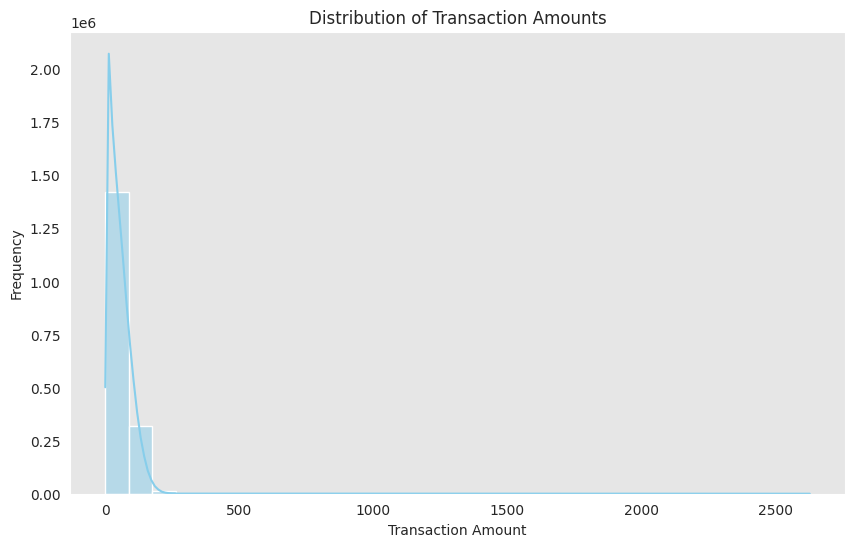

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=transactions_df, x=transactions_df['TX_AMOUNT'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Interpretation
This histogram shows the distribution of transaction amounts. We can see that most of the transaction amounts are in the range of 0 to 500.

# Fraudulent vs. Legitimate Transactions by Time of Day

In [ ]:


import plotly.express as px

fig = px.histogram(transactions_df, x='TX_DURING_NIGHT', color='TX_FRAUD',
                   title='Fraudulent vs Legitimate Transactions by Time of Day',
                   labels={'TX_DURING_NIGHT': 'Time of Day (0: Day, 1: Night)', 'fraud_label': 'Transaction Type'},
                   color_discrete_sequence=['pink', 'salmon'])
fig.update_layout(bargap=0.2)
fig.show()

# Interpretation
This bar chart compares the amount of fraudulent and legitimate transactions during the day versus night. Wecan infer that most of the transactions happens during daytime.

# Weekend vs Weekday Transactions

In [ ]:

import plotly.express as px
fig = px.histogram(transactions_df, x='TX_DURING_WEEKEND', color='TX_FRAUD',
                   title='Weekend vs Weekday Transactions',
                   labels={'TX_DURING_WEEKEND': 'Transaction Day (0: Weekday, 1: Weekend)', 'fraud_label': 'Transaction Type'},
                   color_discrete_sequence=['skyblue', 'blue'])
fig.update_layout(bargap=0.2)
fig.show()

# Interpretation
This histogram compares the amount of transactions on weekends versus weekdays for both fraudulent and legitimate transactions. We can infer that most of the transactions occur during weekdays.

# Correlation Heatmap

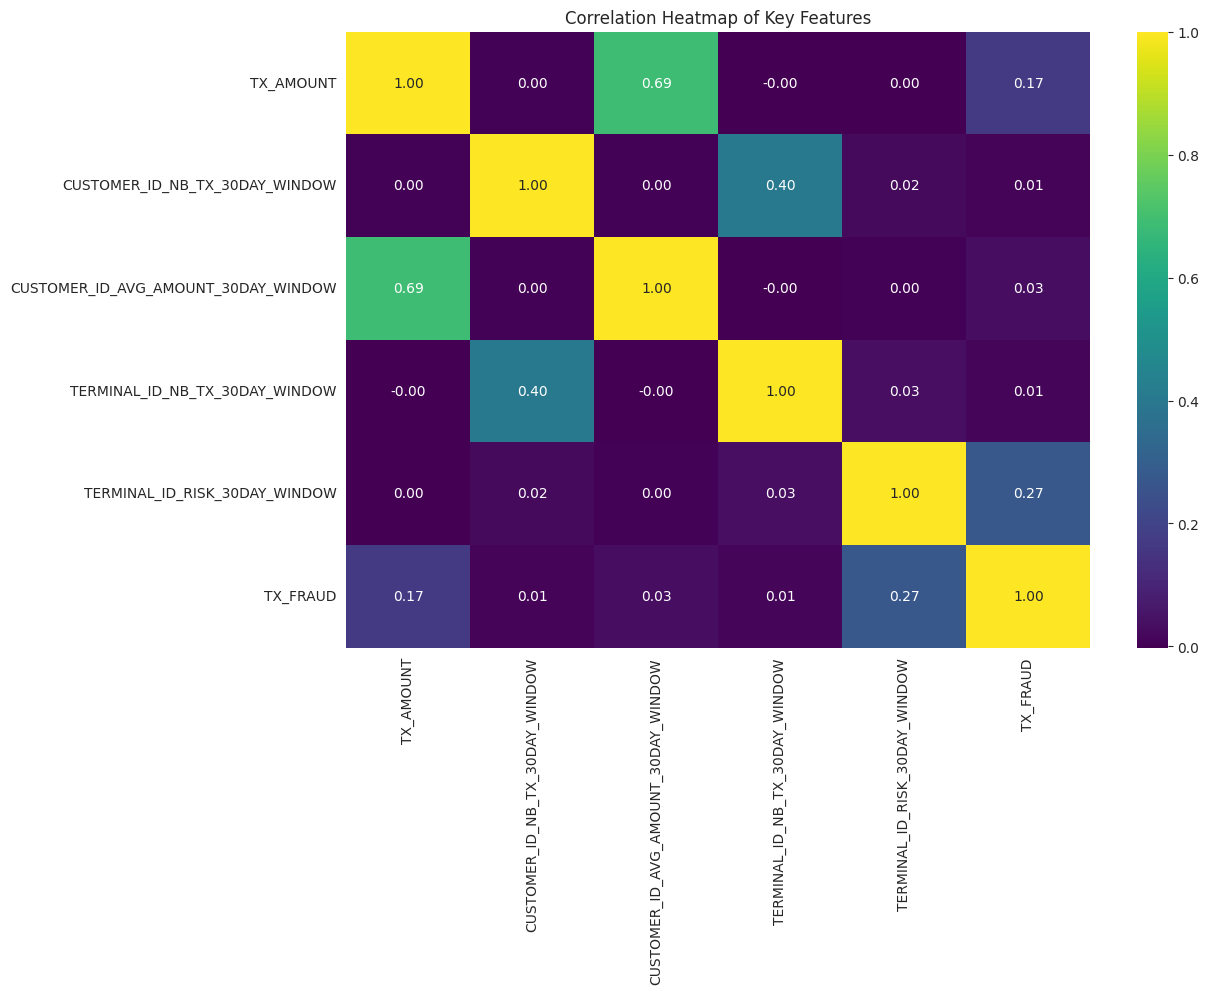

In [ ]:

plt.figure(figsize=(12, 8))
correlation_matrix = transactions_df[[ 'TX_AMOUNT', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
                          'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
                          'TERMINAL_ID_NB_TX_30DAY_WINDOW',
                          'TERMINAL_ID_RISK_30DAY_WINDOW',
                          'TX_FRAUD']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Key Features')
plt.show()

# Interpretation
The heatmap displays correlations between the key features. Correlation beyond 0.8 may indicate that the features are dependent on each other. Overhere, all the features are linearly independent.

# Average Transaction Frequency per Customer

<ipython-input-39-51a57047d634>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




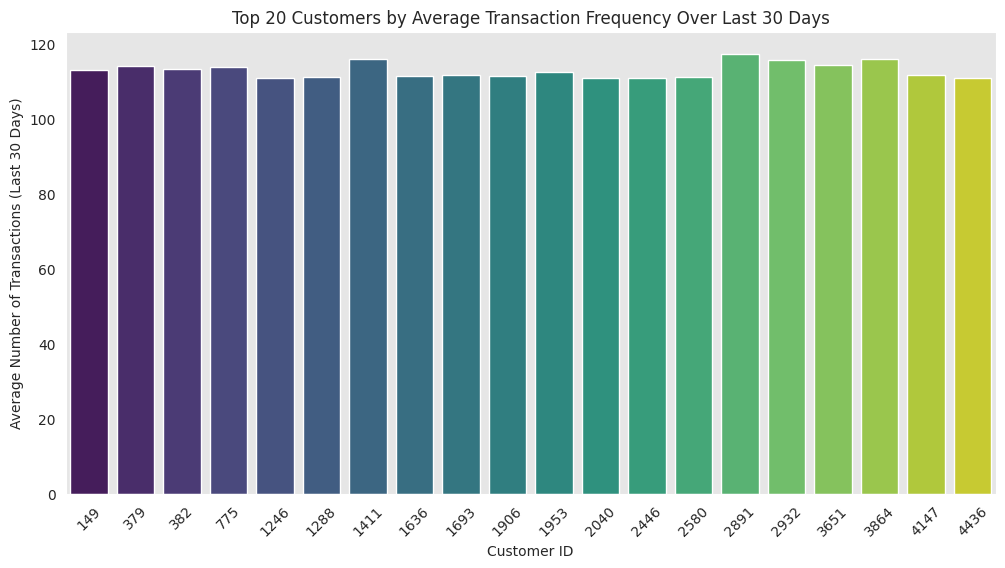

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


avg_transactions = transactions_df.groupby('CUSTOMER_ID')['CUSTOMER_ID_NB_TX_30DAY_WINDOW'].mean().reset_index()

avg_transactions = avg_transactions.sort_values(by='CUSTOMER_ID_NB_TX_30DAY_WINDOW', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(data=avg_transactions.head(20), x='CUSTOMER_ID', y='CUSTOMER_ID_NB_TX_30DAY_WINDOW', palette='viridis')
plt.title('Top 20 Customers by Average Transaction Frequency Over Last 30 Days')
plt.xlabel('Customer ID')
plt.ylabel('Average Number of Transactions (Last 30 Days)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Interpretation
This bar plot displays the top 20 customers based on their average transaction frequency over the last 30 days.

#Transaction Amount vs. Average Spending Amount

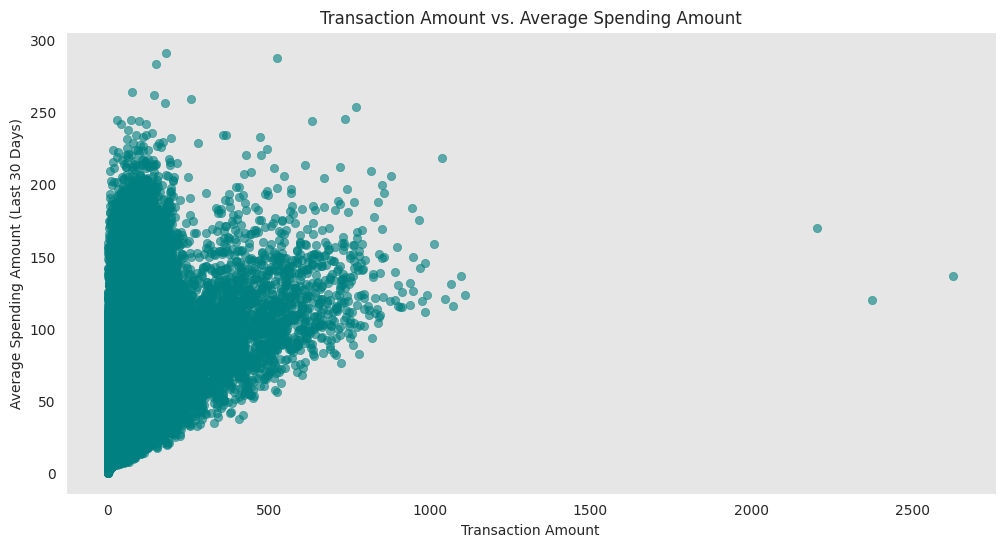

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns


scatter_data = transactions_df[['TX_AMOUNT', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW','TX_FRAUD']]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_data, x='TX_AMOUNT', y='CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
                 alpha=0.6, edgecolor=None,color='teal')
plt.title('Transaction Amount vs. Average Spending Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Average Spending Amount (Last 30 Days)')
plt.grid()



plt.show()

# Interpretation
This scatter plot visualizes the relationship between transaction amounts and average spending amounts. Each point represents a transaction, plotted by its amount against the average spending of the customer over the last 30 days. As we can see the scatter plot are as a cluster there is no relationship between transaction amount and average spending amount.

#  Average transaction amount over time

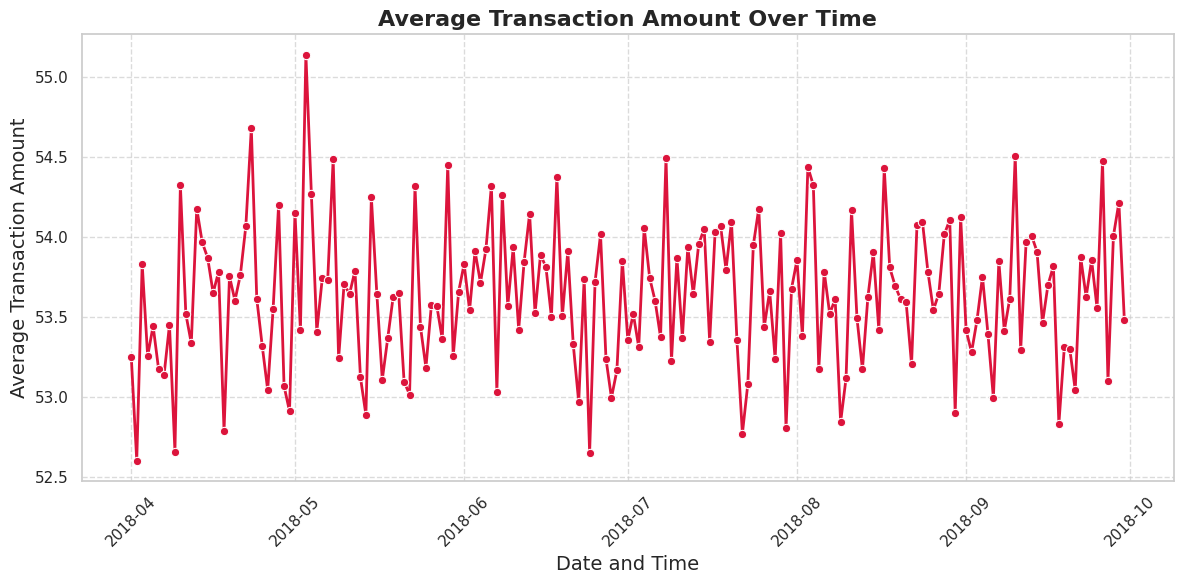

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='whitegrid')
transactions_df['TX_DATETIME'] = pd.to_datetime(transactions_df['TX_DATETIME'])
daily_avg = transactions_df.resample('D', on='TX_DATETIME').mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='TX_DATETIME', y='TX_AMOUNT', data=daily_avg, marker='o', color='crimson', linewidth=2)


plt.title('Average Transaction Amount Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date and Time', fontsize=14)
plt.ylabel('Average Transaction Amount', fontsize=14)
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Interpretation
The plot provides a visual representation of how average transaction amounts change over time.

In [ ]:
import pandas as pd
transactions_df=pd.read_csv('/content/transactions_df.csv')
transactions_df.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD',
       'TX_FRAUD_SCENARIO', 'TX_DURING_WEEKEND', 'TX_DURING_NIGHT',
       'CUSTOMER_ID_NB_TX_1DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
       'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
       'TERMINAL_ID_NB_TX_1DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW',
       'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW',
       'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW'],
      dtype='object')

In [ ]:
!pip install phe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.4 MB/s eta 0:00:00


# XG BOOST

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import time
import psutil

# Load the dataset
data_path = "C:/Users/Samridhaa/OneDrive/Documents/New folder/shrunk_dataset.csv"
df = pd.read_csv(data_path).dropna(subset=['TX_FRAUD'])

# Define features and target variable
features = [
    'TX_AMOUNT', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
    'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW',
    'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW'
]
X = df[features]
y = df['TX_FRAUD']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# APPLYING SMOTE

In [ ]:
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print the distribution after SMOTE
print("SMOTE APPLIED")


SMOTE APPLIED


# LEARNING CURVE

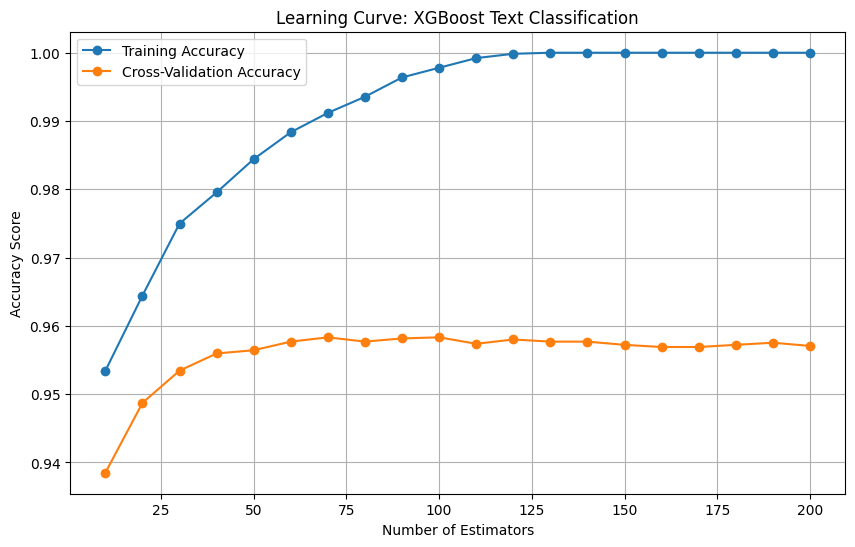

In [ ]:
# Initialize XGBoost Classifier
model = XGBClassifier(eval_metric='mlogloss')

# Containers to store scores for learning curve
train_scores = []
cv_scores = []


for i in range(10, 201, 10):
    model.set_params(n_estimators=i)
    model.fit(X_train_balanced, y_train_balanced)


    train_pred = model.predict(X_train_balanced)
    train_score = accuracy_score(y_train_balanced, train_pred)
    train_scores.append(train_score)

    # Calculate cross-validation accuracy
    cv_score = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy').mean()
    cv_scores.append(cv_score)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(range(10, 201, 10), train_scores, label='Training Accuracy', marker='o')
plt.plot(range(10, 201, 10), cv_scores, label='Cross-Validation Accuracy', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve: XGBoost Text Classification')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# HYPER PARAMETER TUNING

In [ ]:
# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [ ]:
from sklearn.model_selection import cross_val_score
start_time = time.time()
process = psutil.Process()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(X_train_balanced, y_train_balanced)

best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

best_model.fit(X_train_balanced, y_train_balanced)
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

eval_latency = time.time() - start_time
eval_memory = process.memory_info().rss / (1024 * 1024)

print(f"Latency: {eval_latency:.2f}s, Memory Usage: {eval_memory:.2f} MB")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Model:", best_model)

# Print cross-validation results
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Latency: 1070.53s, Memory Usage: 280.41 MB
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.960209858032847
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)
Cross-Validation Accuracy Scores: [

# EVALUATION METRICS

In [ ]:
print("Evaluation Metrics on Test Set:")
print(f"Accuracy: { accuracy* 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Evaluation Metrics on Test Set:
Accuracy: 96.02%
Precision: 0.9267
Recall: 0.7809
F1 Score: 0.8476
ROC AUC Score: 0.9080


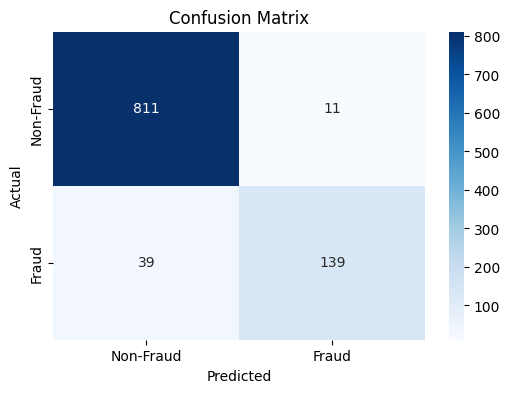

Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.95      0.99      0.97       822
       Fraud       0.93      0.78      0.85       178

    accuracy                           0.95      1000
   macro avg       0.94      0.88      0.91      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))

# ROC CURVE

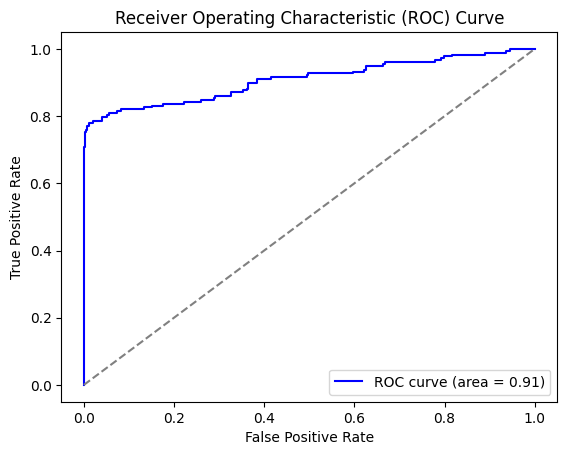

In [ ]:
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# FIRST DECISION TREE PLOT USING XGBOOST

<Figure size 2000x1000 with 0 Axes>

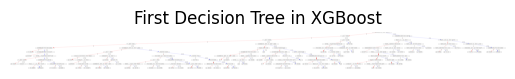

In [ ]:
from xgboost import plot_tree

# Visualizing the first decision tree in the XGBoost model
plt.figure(figsize=(20, 10))
# Pass fontsize within leaf_node_params
plot_tree(best_model, num_trees=0, fmap='', title="First Decision Tree in XGBoost")
plt.title("First Decision Tree in XGBoost")
plt.show()

# FEATURE SELCTION USING XGBOOST

<ipython-input-12-ba8be92375ac>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


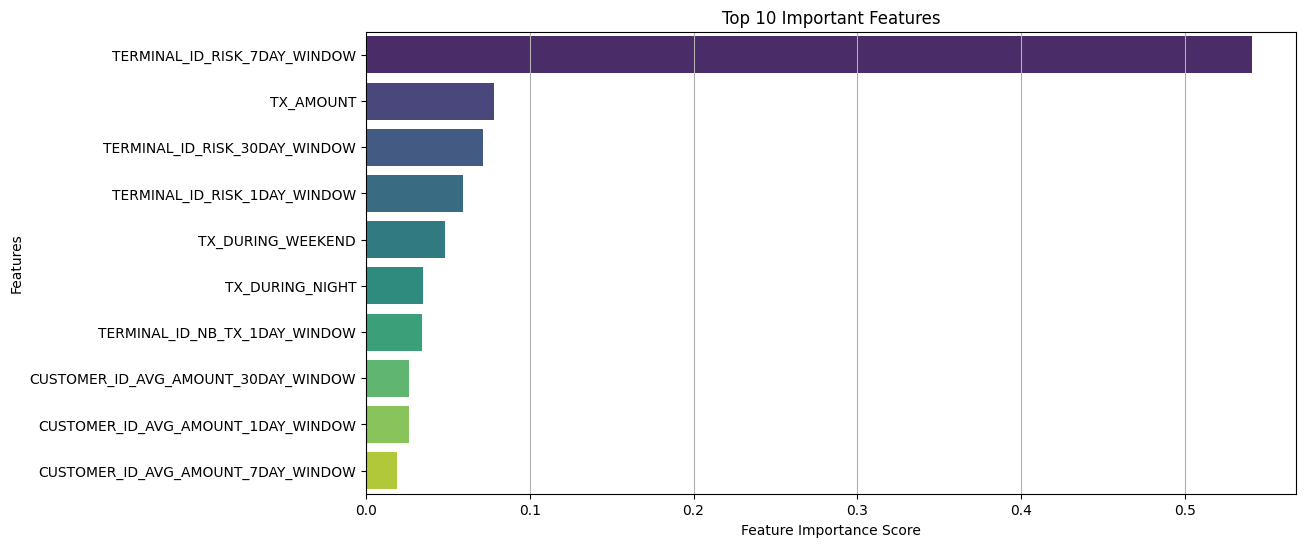

In [ ]:
#Feature importance
importances = best_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Get the top 10 important features
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.grid(axis='x')

# Show the plot
plt.show()

# EVALUATION METRICS GRAPH OF XGBOOST

<ipython-input-13-1dfc56fb9416>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')


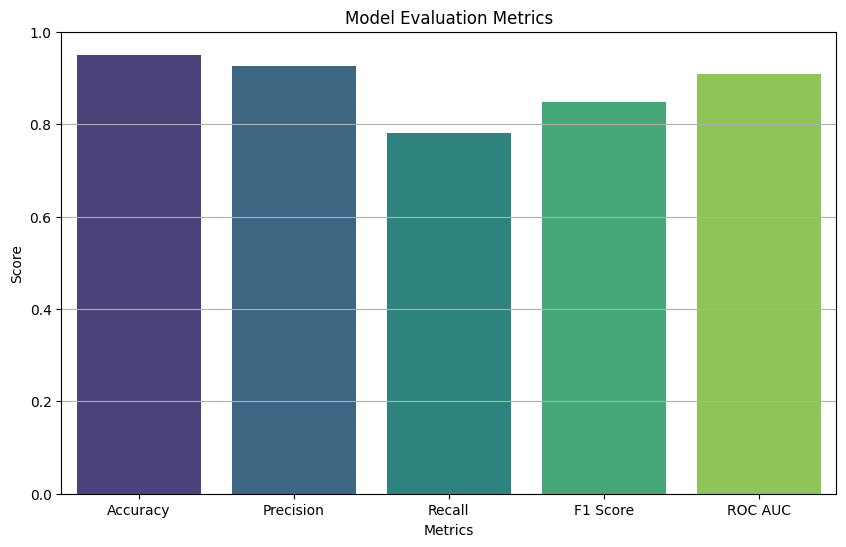

In [ ]:

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

# Convert to DataFrame for easy plotting
metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # Set y-axis limits to be between 0 and 1
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.grid(axis='y')

# Show the plot
plt.show()

In [ ]:
!pip install phe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.6 MB/s eta 0:00:00


# ENCRYPTION ON XGBOOST

In [ ]:
import phe as paillier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from joblib import Parallel, delayed, dump, load
import pandas as pd
import numpy as np
import re
import time
import os
import pickle
def generate_keys():

    return paillier.generate_paillier_keypair()

def save_keys(public_key, private_key, file_path: str):

    with open(file_path, 'wb') as f:
        pickle.dump((public_key, private_key), f)

def load_keys(file_path: str):

    with open(file_path, 'rb') as f:
        public_key, private_key = pickle.load(f)
    return public_key, private_key

def ope_encrypt(value: float, key: int, min_val: float = 0, max_val: float = 1000) -> int:

    encrypted_range = 10**6
    scaled_value = int((value - min_val) / (max_val - min_val) * encrypted_range)
    encrypted_value = (scaled_value + key) % encrypted_range
    return encrypted_value

def ope_decrypt(encrypted_value: int, key: int, min_val: float = 0, max_val: float = 1000) -> float:

    encrypted_range = 10**6
    shifted_value = (encrypted_value - key) % encrypted_range
    original_value = (shifted_value / encrypted_range) * (max_val - min_val) + min_val
    return original_value

public_key, private_key = generate_keys()
ope_key = 42


key_file_path = 'C:/Users/Samridhaa/OneDrive/Desktop/ML2/keys_xg.pkl'
save_keys(public_key, private_key,key_file_path)
print(f"Keys saved to {key_file_path}.")

public_key_loaded, private_key_loaded= load_keys(key_file_path)
print("Keys loaded from file.")

def load_data(file_path: str) -> pd.DataFrame:

    try:
        df = pd.read_csv(file_path).dropna(subset=['TX_FRAUD'])
        return df
    except FileNotFoundError:
        raise Exception(f"File not found: {file_path}")

data_path = "C:/Users/Samridhaa/OneDrive/Documents/New folder/shrunk_dataset.csv"
df = load_data(data_path)


features = [
    'TX_AMOUNT', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
    'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW',
    'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW'
]
X = df[features]
y = df['TX_FRAUD']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE applied.")


start_time = time.time()
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print("Model trained.")
print(f"Training time: {end_time - start_time:.4f} seconds.")


model_filename = 'C:/Users/Samridhaa/OneDrive/Desktop/ML2/xgb_model.joblib'
dump(xgb_model, model_filename)
print(f"Model saved as {model_filename}.")


xgb_model_loaded = load(model_filename)
print("Model loaded.")


booster = xgb_model_loaded.get_booster()
trees = booster.get_dump()

def encrypt_node(value: float, use_paillier: bool = True):

    min_val, max_val = X.min().min(), X.max().max()
    return (
        public_key.encrypt(value)
        if use_paillier
        else ope_encrypt(value, ope_key, min_val, max_val)
    )

def process_tree(tree: str):

    encrypted_tree = []
    for node in tree.split('\n'):
        if 'leaf' in node:
            match = re.search(r'leaf=(\S+)', node)
            if match:
                leaf_value = float(match.group(1))
                encrypted_tree.append(encrypt_node(leaf_value, use_paillier=True))
        else:
            match = re.search(r'<([\d.]+)', node)
            if match:
                split_value = float(match.group(1))
                encrypted_tree.append(encrypt_node(split_value, use_paillier=False))
    return encrypted_tree


start_time = time.time()
encrypted_trees = Parallel(n_jobs=-1)(delayed(process_tree)(tree) for tree in trees)
end_time = time.time()
print(f"Time taken to encrypt trees: {end_time - start_time:.4f} seconds.")


with open('C:/Users/Samridhaa/OneDrive/Desktop/ML2/encrypted_trees.pkl', 'wb') as f:
    pickle.dump(encrypted_trees, f)
print("Encrypted trees saved.")


def load_encrypted_trees(filename: str):
    with open(filename, 'rb') as f:
        return pickle.load(f)


encrypted_trees_loaded = load_encrypted_trees('C:/Users/Samridhaa/OneDrive/Desktop/ML2/encrypted_trees.pkl')
print("Encrypted trees loaded.")


def encrypted_prediction(tree, x_instance):
    """Predict for a single tree using encrypted nodes by traversing from root to leaf."""
    node = tree[0]
    while not node.is_leaf:
      threshold = ope_decrypt(node.split_threshold, ope_key, min_val=X.min().min(), max_val=X.max().max())
      if x_instance[node.split_feature] < threshold:
            node = node.left_child
      else:

            node = node.right_child

   return node

def predict_for_sample(j: int) -> float:
    """Predict for one sample across all trees."""
    sample_preds = [
        encrypted_prediction(encrypted_trees_loaded[i], X_test.iloc[j])
        for i in range(len(encrypted_trees_loaded))
    ]
    aggregated = sum(sample_preds)
    return private_key.decrypt(aggregated) / len(encrypted_trees_loaded)


start_time = time.time()
y_pred_encrypted = Parallel(n_jobs=-1)(delayed(predict_for_sample)(j) for j in range(len(X_test)))
end_time = time.time()
print(f"Prediction Latency: {end_time - start_time:.4f} seconds.")


y_pred_binary = [0 if p >= 0.5 else 1 for p in y_pred_encrypted]

storage_size = os.path.getsize(model_filename) / (1024 ** 2)
print(f"Model storage size: {storage_size:.2f} MB")

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on Encrypted Data: {accuracy*100:.2f}%")


Keys saved to C:/Users/Samridhaa/OneDrive/Desktop/ML2/keys_xg.pkl.
Keys loaded from file.
SMOTE applied.
Model trained.
Training time: 0.1930 seconds.
Model saved as C:/Users/Samridhaa/OneDrive/Desktop/ML2/xgb_model.joblib.
Model loaded.
Time taken to encrypt trees: 31.7397 seconds.
Encrypted trees saved.
Encrypted trees loaded.
Prediction Latency: 185.2690 seconds.
Model storage size: 0.11 MB
Accuracy on Encrypted Data: 82.20%


In [ ]:
!pip install phe

# RANDOM FOREST

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import time
import psutil
data_path = "C:/Users/Samridhaa/OneDrive/Documents/New folder/shrunk_dataset.csv"
df = pd.read_csv(data_path).dropna(subset=['TX_FRAUD'])
features = [
    'TX_AMOUNT', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
    'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW',
    'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW'
]
X = df[features]
y = df['TX_FRAUD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# APPLYING SMOTE

In [ ]:

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("SMOTE APPLIED")


SMOTE APPLIED


# LEARNING CURVE

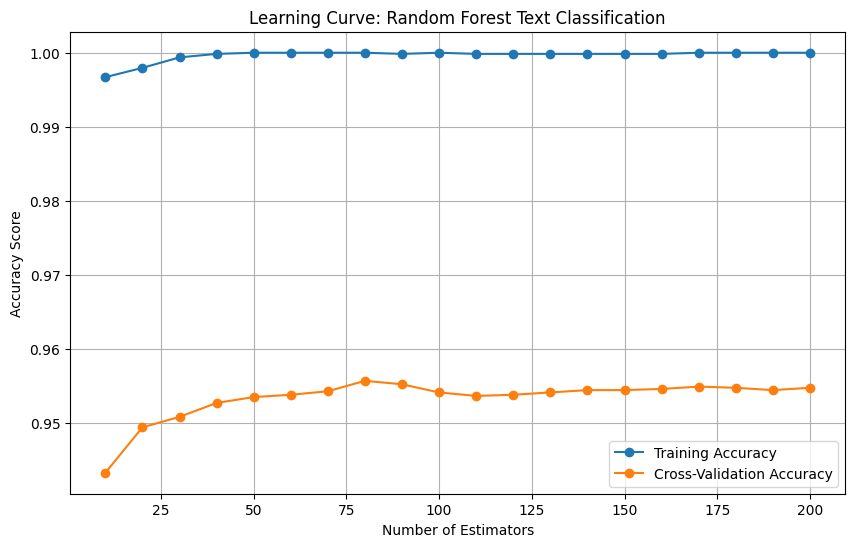

In [ ]:

model = RandomForestClassifier(random_state=42)

train_scores = []
cv_scores = []
for i in range(10, 201, 10):
    model.set_params(n_estimators=i)
    model.fit(X_train_balanced, y_train_balanced)


    train_pred = model.predict(X_train_balanced)
    train_score = accuracy_score(y_train_balanced, train_pred)
    train_scores.append(train_score)


    cv_score = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy').mean()
    cv_scores.append(cv_score)


plt.figure(figsize=(10, 6))
plt.plot(range(10, 201, 10), train_scores, label='Training Accuracy', marker='o')
plt.plot(range(10, 201, 10), cv_scores, label='Cross-Validation Accuracy', marker='o')

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve: Random Forest Text Classification')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# HYPER PARAMETER TUNING

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:


start_time = time.time()
process = psutil.Process()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(X_train_balanced, y_train_balanced)

best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')


best_model.fit(X_train_balanced, y_train_balanced)
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

eval_latency = time.time() - start_time
eval_memory = process.memory_info().rss / (1024 * 1024)

print(f"Latency: {eval_latency:.2f}s, Memory Usage: {eval_memory:.2f} MB")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Model:", best_model)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Latency: 2142.00s, Memory Usage: 143.22 MB
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9591071260682174
Best Model: RandomForestClassifier(bootstrap=False, n_estimators=200, random_state=42)
Cross-Validation Accuracy Scores: [0.87421384 0.95830055 0.98819827 0.9913454  0.98347758]
Mean Cross-Validation Accuracy: 0.9591071260682174


# EVALUATION METRICS

In [ ]:
print("Evaluation Metrics on Test Set:")
print(f"Accuracy: { accuracy* 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Evaluation Metrics on Test Set:
Accuracy: 95.91%
Precision: 0.9205
Recall: 0.7809
F1 Score: 0.8450
ROC AUC Score: 0.9000


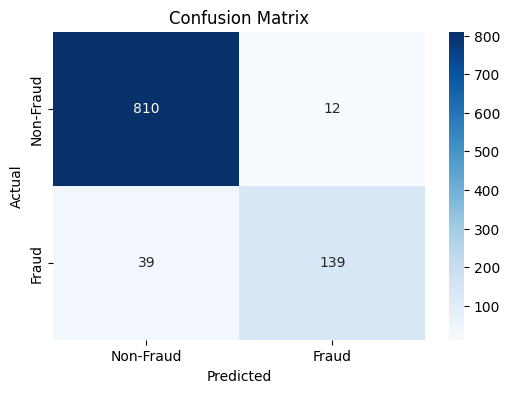

Classification Report:
               precision    recall  f1-score   support

   Non-Fraud       0.95      0.99      0.97       822
       Fraud       0.92      0.78      0.84       178

    accuracy                           0.95      1000
   macro avg       0.94      0.88      0.91      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))

# ROC CURVE

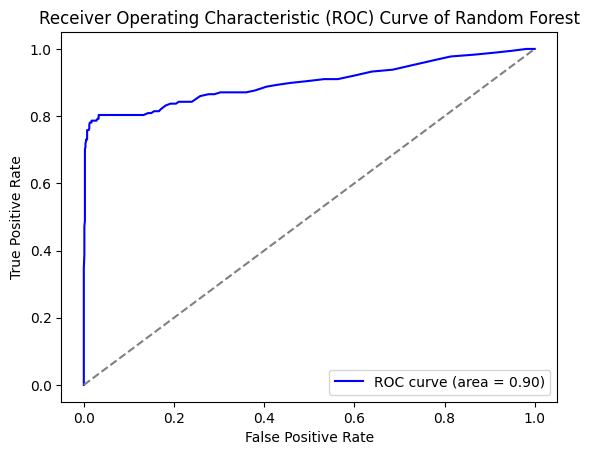

In [ ]:
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of Random Forest')
plt.legend(loc='lower right')
plt.show()

# FIRST DECISION TREE PLOT OF RANDOM FOREST

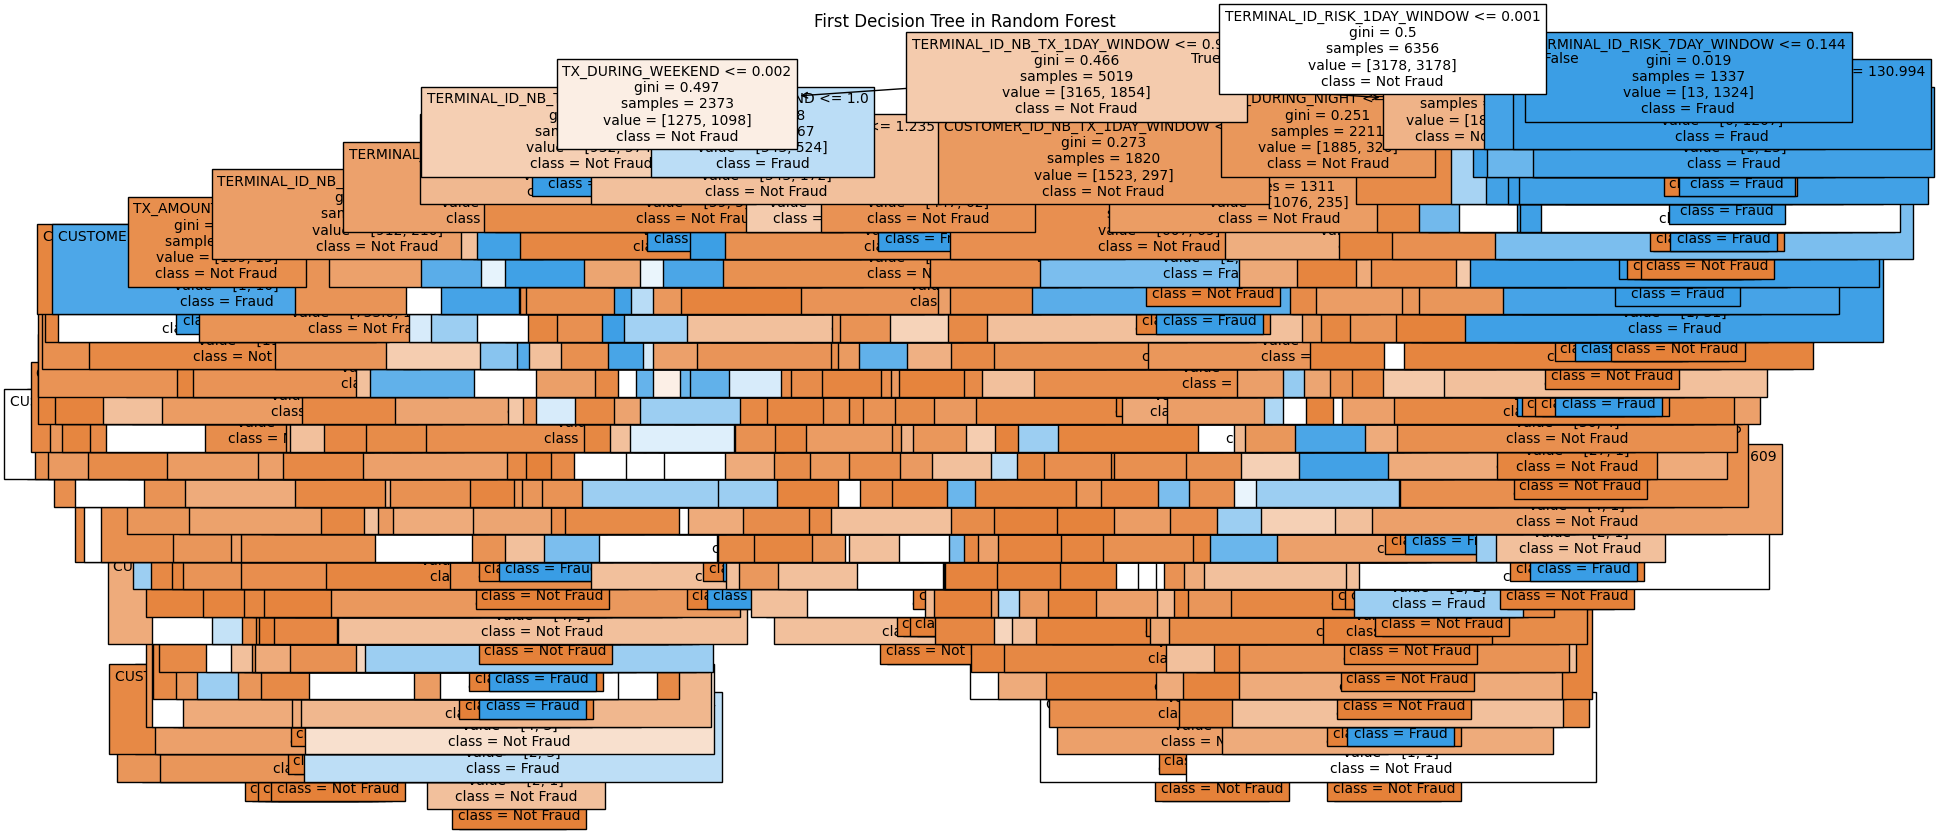

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

first_tree = best_model.estimators_[0]

plot_tree(first_tree, filled=True, fontsize=10, feature_names=features, class_names=['Not Fraud', 'Fraud'])
plt.title("First Decision Tree in Random Forest")
plt.show()

# FEATURE SELECTION USING RANDOM FOREST

C:\Users\Samridhaa\AppData\Local\Temp\ipykernel_58200\2249671282.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


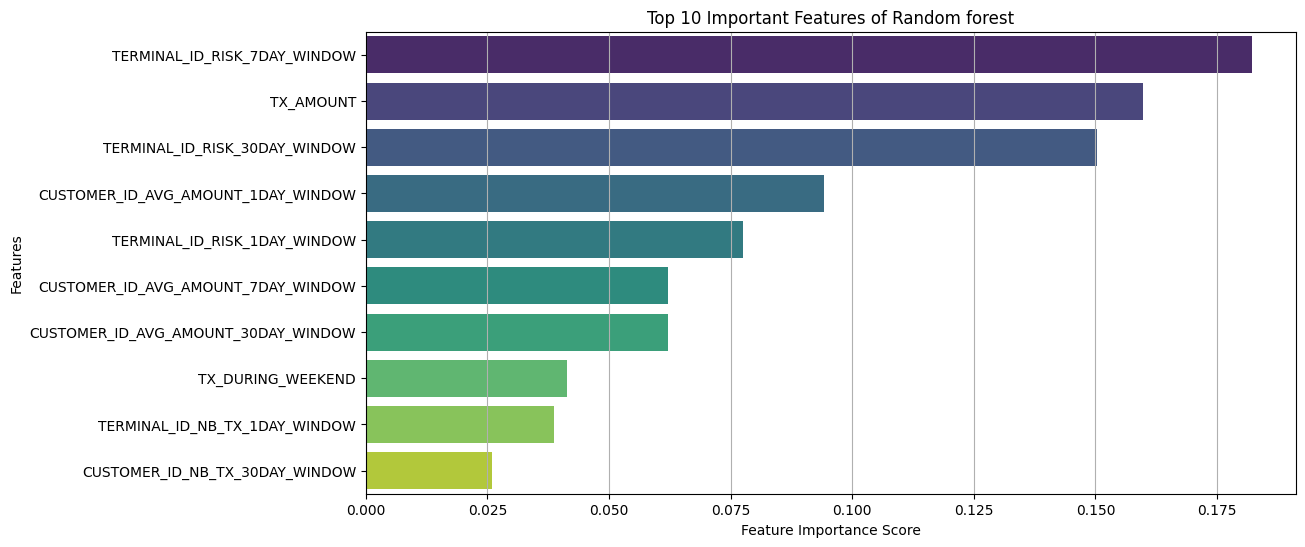

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_model.feature_importances_
feature_names = X_train.columns


feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)


plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Important Features of Random forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.grid(axis='x')

plt.show()

# EVALUATION METRICS GRAPH OF RANDOM FOREST

C:\Users\Samridhaa\AppData\Local\Temp\ipykernel_58200\353025881.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')


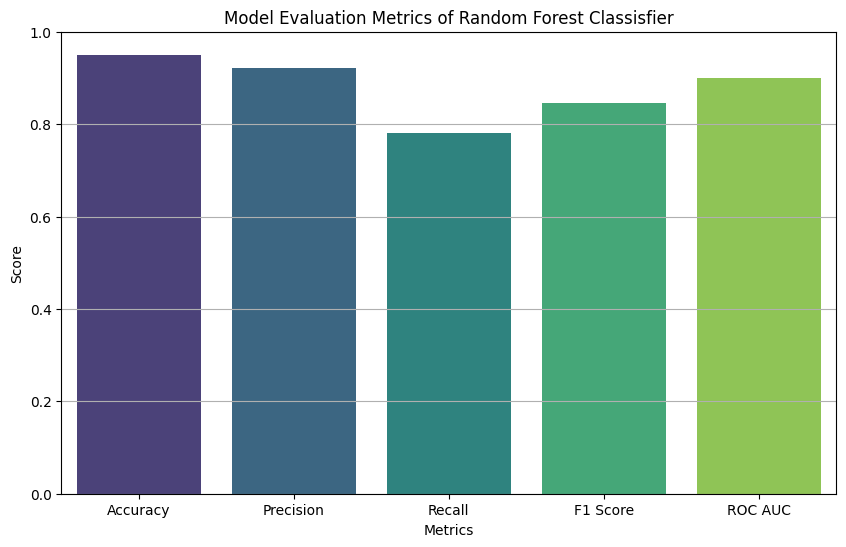

In [ ]:

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
}

metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Value'])


plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')
plt.title('Model Evaluation Metrics of Random Forest Classisfier')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.grid(axis='y')
plt.show()

# ENCRYPTION ON RANDOM FOREST

In [ ]:
import phe as paillier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed, dump, load
import pandas as pd
import numpy as np
import os
import pickle
import time
def generate_keys():

    return paillier.generate_paillier_keypair()

def save_keys(public_key, private_key,file_path: str):
    with open(file_path, 'wb') as f:
        pickle.dump((public_key, private_key), f)

def load_keys(file_path: str):
    with open(file_path, 'rb') as f:
        public_key, private_key = pickle.load(f)
    return public_key, private_key

def ope_encrypt(value: float, key: int, min_val: float = 0, max_val: float = 1000) -> int:
    encrypted_range = 10**6
    scaled_value = int((value - min_val) / (max_val - min_val) * encrypted_range)
    encrypted_value = (scaled_value + key) % encrypted_range
    return encrypted_value

def ope_decrypt(encrypted_value: int, key: int, min_val: float = 0, max_val: float = 1000) -> float:
    encrypted_range = 10**6
    shifted_value = (encrypted_value - key) % encrypted_range
    original_value = (shifted_value / encrypted_range) * (max_val - min_val) + min_val
    return original_value


public_key, private_key = generate_keys()
ope_key = 42

key_file_path = 'C:/Users/Samridhaa/OneDrive/Desktop/ML2/keys_rf.pkl'
save_keys(public_key, private_key,key_file_path)
print(f"Keys saved to {key_file_path}.")

public_key_loaded, private_key_loaded = load_keys(key_file_path)
print("Keys loaded from file.")

def load_data(file_path: str) -> pd.DataFrame:

    try:
        df = pd.read_csv(file_path).dropna(subset=['TX_FRAUD'])
        return df
    except FileNotFoundError:
        raise Exception(f"File not found: {file_path}")

data_path = "C:/Users/Samridhaa/OneDrive/Documents/New folder/shrunk_dataset.csv"
df = load_data(data_path)

features = [
    'TX_AMOUNT', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
    'TERMINAL_ID_NB_TX_30DAY_WINDOW', 'TERMINAL_ID_RISK_30DAY_WINDOW',
    'TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_NB_TX_7DAY_WINDOW', 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_NB_TX_7DAY_WINDOW', 'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_RISK_7DAY_WINDOW'
]
X = df[features]
y = df['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE applied.")

start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=-1, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
print("Random Forest Model trained.")
print(f"Training time: {end_time - start_time:.4f} seconds.")

# Save the model
model_filename = 'C:/Users/Samridhaa/OneDrive/Desktop/ML2/rf_model.joblib'
dump(rf_model, model_filename)
print(f"Random Forest Model saved as {model_filename}.")


rf_model_loaded = load(model_filename)
print("Random Forest Model loaded.")


trees = rf_model_loaded.estimators_

def encrypt_node(value: float, use_paillier: bool = True):
    """Encrypt a node value with Paillier or improved OPE."""
    min_val, max_val = X.min().min(), X.max().max()
    return (
        public_key.encrypt(value)
        if use_paillier
        else ope_encrypt(value, ope_key, min_val, max_val)
    )

def process_tree(tree):

    tree_str = tree.tree_.__getstate__()['nodes']
    encrypted_tree = []
    for node in tree_str:
        if node[2] == -1:
            leaf_value = node[3]
            encrypted_tree.append(encrypt_node(leaf_value, use_paillier=True))
        else:
            split_value = node[3]
            encrypted_tree.append(encrypt_node(split_value, use_paillier=False))
    return encrypted_tree

start_time = time.time()
encrypted_trees = Parallel(n_jobs=-1)(delayed(process_tree)(tree) for tree in trees)
end_time = time.time()
print(f"Time taken to encrypt trees: {end_time - start_time:.4f} seconds.")


with open('C:/Users/Samridhaa/OneDrive/Desktop/ML2/encrypted_trees_rf.pkl', 'wb') as f:
    pickle.dump(encrypted_trees, f)
print("Encrypted trees saved.")


def load_encrypted_trees(filename: str):
    """Load encrypted trees from a file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

encrypted_trees_loaded_rf = load_encrypted_trees('C:/Users/Samridhaa/OneDrive/Desktop/ML2/encrypted_trees_rf.pkl')
print("Encrypted trees loaded.")

def encrypted_prediction(encrypted_tree, x_instance):

    node_id = 0
    while True:
        if node_id == -1:
            return encrypted_tree[node_id]

        threshold = ope_decrypt(encrypted_tree[node_id], ope_key, min_val=X.min().min(), max_val=X.max().max())


        feature_index = trees[node_id].tree_.feature[node_id]
        if x_instance[feature_index] <= threshold:
            node_id = trees[node_id].tree_.children_left[node_id]
        else:
            node_id = trees[node_id].tree_.children_right[node_id]

def predict_for_sample(j: int) -> float:
    """Predict for one sample across all trees in the Random Forest model."""
    sample_preds = [
        encrypted_prediction(encrypted_trees_loaded_rf[i], X_test.iloc[j])
        for i in range(len(encrypted_trees_loaded_rf))
    ]

    aggregated = sum(sample_preds)
    return private_key.decrypt(aggregated) / len(encrypted_trees_loaded)


start_time = time.time()
y_pred_encrypted = Parallel(n_jobs=-1)(delayed(predict_for_sample)(j) for j in range(len(X_test)))
end_time = time.time()
print(f"Prediction Latency: {end_time - start_time:.4f} seconds.")


y_pred_binary = [0 if p >= 0.5 else 1 for p in y_pred_encrypted]

storage_size = os.path.getsize(model_filename) / (1024 ** 2)
print(f"Model storage size: {storage_size:.2f} MB")


accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy on Encrypted Data with Random Forest: {accuracy*100:.2f}%")


Keys saved to C:/Users/Samridhaa/OneDrive/Desktop/ML2/keys_rf.pkl.
Keys loaded from file.
SMOTE applied.
Random Forest Model trained.
Training time: 0.2792 seconds.
Random Forest Model saved as C:/Users/Samridhaa/OneDrive/Desktop/ML2/rf_model.joblib.
Random Forest Model loaded.
Time taken to encrypt trees: 2.6933 seconds.
Encrypted trees saved.
Encrypted trees loaded.
Prediction Latency: 47.6493 seconds.
Model storage size: 0.15 MB
Accuracy on Encrypted Data with Random Forest: 82.20%
